In this tutorial, we produce a list of Twitter screen names, collect their retweets over the last week, bind them together into a network, and finally use community detection to partition them into groups of well inter-connected individuals.

## Tutorial contents
* [Linking Twitter accounts](#Linking-twitter-accounts)
* [Collecting retweets](#Collecting-retweets)
* [Building a network](#Building-a-network)
* [Detecting communities](#Detecting-communities)

## Linking Twitter accounts

Our analysis is rooted in the community formation of two sets of nodes; the Members of Parliament who won or retained their seat in the 2015 general election (or subsequent byelection to fill a vacancy) and the UK members of the European Parliament elected in the 2014 European Parliament election. Each of these nodes may have zero or more affiliated Twitter accounts, either personal or exclusive to the 2015 campaigning period. Since the start of 2015 campaigning there have been four instances of seats changing hands, resulting in a total of 654 MPs and 73 UK MEPs. Of these we find 591 MPs and 70 MEPs to have had affiliated Twitter accounts at some point. Note closure or suspension of accounts will reduce this number over time, along with the opening of new affiliated accounts.

In [61]:
import csv

F_NAME_AFFILIATIONS = 'mp_mep_twitter_accounts.csv'

with open(F_NAME_AFFILIATIONS,'r') as f_in:
	reader	= csv.reader(f_in, delimiter=',', quotechar='"')
	headers	= next(reader);
	mp_mep_twitter = {row[2]:row[8].split(',') for row in reader if row[8]}
    
screen_name_list = [account for user in mp_mep_twitter.values() for account in user]

print 'Number of nodes:\t%s'%len(mp_mep_twitter.keys())
print 'Number of accounts:\t%s'%len(screen_name_list)

Number of nodes:	661
Number of accounts:	733


## Collecting retweets

Having established an inclusive list of Twitter accounts, these can be used to collect retweets over any time period chosen. In this example, we collect retweets over the last week


In [62]:
import datetime

today = datetime.date.today()

start_date = today - datetime.timedelta(days = today.weekday(), weeks = 1)
end_date   = start_date + datetime.timedelta(days = 7)

print 'Start date:\t%s' % start_date.isoformat()
print 'End date:\t%s' % end_date.isoformat()

Start date:	2016-12-05
End date:	2016-12-12


We will collect the user timelines exactly as described in the [Tweepy tutorial](???), limited to the chosen period by setting limits on the tweet ID numbers returned. Fortunately, converting between tweet ID and real time is simple enough, although timezone considerations may need incorporating in some cases.

In [56]:
import time

def utc2snowflake(utc_timestamp):
    return (int(round(utc_timestamp * 1000)) - 1288834974657) << 22

max_id = utc2snowflake(time.mktime(end_date.timetuple()))
min_id = utc2snowflake(time.mktime(start_date.timetuple()))

print 'min_id:\t%s' % min_id
print 'max_id:\t%s' % max_id

min_id:	805562326840246272
max_id:	808099041899446272


Retweets are identified by the presence of the 'retweeted_status' field, which contains information about the original Tweet, most importantly the user who made it.

It is entirely possible that we encounter your rate limit during this exercise, and so we must be prepared to handle this appropriately, either by waiting the 15 minutes it takes for the limit to be renewed, or simply continuing with incomplete data. This code will wait for the rate limit to refresh and continue collecting tweets.

In [38]:
import tweepy
import json

CONSUMER_KEY        = 'your-consumer-key'
CONSUMER_KEY_SECRET = 'your-consumer-key-secret'
ACCESS_TOKEN        = 'your-access-token'
ACCESS_TOKEN_SECRET = 'your-access-token-secret'

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_KEY_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

F_NAME = 'mp_retweet_data_(%s_to_%s).json' % (start_date.isoformat(), end_date.isoformat())

tweets_read = 0
sn_read = 0
with open(F_NAME,'w') as f_out:
    for screen_name in screen_name_list:
        try:
            search = api.user_timeline(screen_name = screen_name, min_id = min_id, max_id = max_id, include_rts = True)
        except tweepy.TweepError:
            pass # can't get records from this user, probably a protected account and it is safe to skip
        else:
            for result in search:
                tweet = result._json
                if tweet.get('retweeted_status'):
                    json.dump(tweet, f_out)
                    f_out.write('\n')
                    tweets_read += 1
            sn_read += 1
            print '\rUsers read:\t%d/%d\tRetweets read:\t%d' % (sn_read, len(screen_name_list), tweets_read),

print '\rUsers read:\t%d/%d\tRetweets read:\t%d\tFinished!' % (sn_read, len(screen_name_list), tweets_read),

Users read:	657/733	Retweets read:	5873	Finished!


## Building a network

Now we have some data, we can create a network between members of the UK parliament. This is a simple case of linking screen_names to MPs, and searching through our data for instances of one retweeting another. This set of edges is simple to transform into a network using Python's networkx library.

Firstly then we return to mp_mep_twitter which gives the screen names of each MP, and this time find the inverse mapping

In [40]:
sn_to_mp = {}
for mp in mp_mep_twitter.keys():
    for sn in mp_mep_twitter[mp]:
            sn_to_mp.update({sn:mp})

F_NAME = 'mp_retweet_data_(%s_to_%s).json' % (start_date.isoformat(), end_date.isoformat())

tweets_read = 0
edge_list   = []
with open(F_NAME,'r') as f_out:
    for result in f_out:
        tweet = json.loads(result)
        tweets_read += 1
        if tweet.get('retweeted_status'):
            mp    = sn_to_mp[tweet['user']['screen_name'].lower()]
            rt_mp = sn_to_mp.get(tweet['retweeted_status']['user']['screen_name'].lower())
            if rt_mp:
                edge_list.append((mp, rt_mp))
                print '\rTweets read:\t%d\tEdges found:\t%d' % (tweets_read, len(edge_list)),
                

Tweets read:	5867	Edges found:	763


Using this data to create a graph could hardly be simpler, and we will soon find analyzing and manipulating the graph is just as straight forward. To make this more interesting, we will also color the nodes in the retweet graph according to the political affiliation of the node; another column of our input file mp_mep_twitter_accounts.csv. Colors have been chosen by those dominant on each party website.

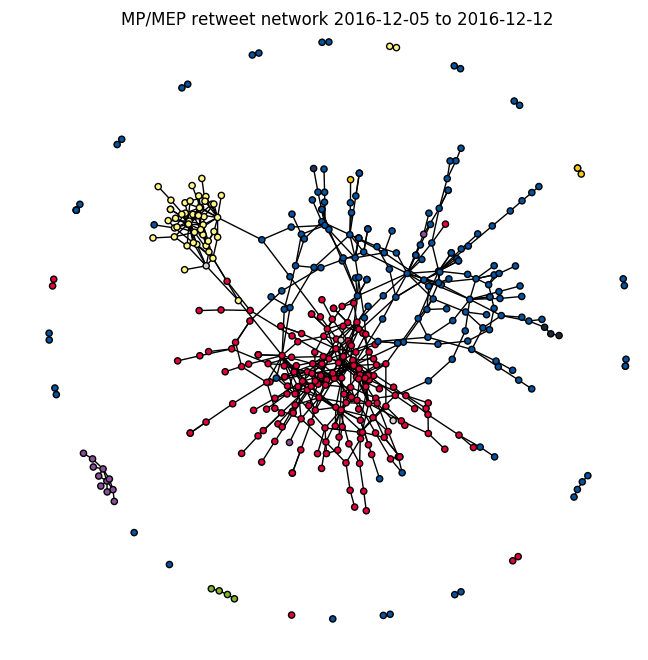

In [140]:
import networkx
import matplotlib.pyplot

G = networkx.Graph()
G.add_edges_from(edge_list)

with open(F_NAME_AFFILIATIONS,'r') as f_in:
	reader	= csv.reader(f_in, delimiter=',', quotechar='"')
	headers	= next(reader);
	mp_mep_affiliation = {row[2]:row[5] for row in reader}
    
color_map = {
    'Conservative':'#00539F',
    'Labour':'#E4003B',
    'Scottish National Party':'#FFF685',
    'United Kingdom Independence Party':'#8C4E9A',
    'Democratic Unionist Party':'#19283E',
    'Liberal Democrat':'#FECB0E',
    'Green Party':'#78B82A',
    'Social Democratic and Labour Party':'#F89828',
    'Plaid Cymru':'#3F8429',
    'Sinn Fein':'#F99D1D',
    'Ulster Unionist Party':'#213362',
    'Independent':'#D3D3D3'}

for node in G.nodes():
    G.node[node]['party'] = mp_mep_affiliation[node]
    
pos = networkx.spring_layout(G, k = .012, iterations = 200)

cut = 0.02
xmin, xmax = min(xx for xx,yy in pos.values()), max(xx for xx,yy in pos.values())
ymin, ymax = min(yy for xx,yy in pos.values()), max(yy for xx,yy in pos.values())
fig = matplotlib.pyplot.figure(1, figsize=(6, 6))

networkx.draw(G, pos, node_size = 20, node_color = [color_map[G.node[node]['party']] for node in G])
matplotlib.pyplot.xlim(xmin - cut * (xmax - xmin), xmax + cut * (xmax - xmin))
matplotlib.pyplot.ylim(ymin - cut * (ymax - ymin), ymax + cut * (ymax - ymin))
matplotlib.pyplot.title('MP/MEP retweet network %s to %s' % (start_date.isoformat(), end_date.isoformat()))

matplotlib.pyplot.show()

## Detecting communities

From the previous figure, community clustering appears trivial. By colouring nodes by party affiliation, we can see large clumps of like-nodes corresponding to MPs and MEPs from different political parties. However humans are also experts at identifying patterns in even random data, so it is important to subject our observations to mathematical rigor. This time we call upon another Python library 'community' to perform community detection, and plot the communities we find as subgraphs.

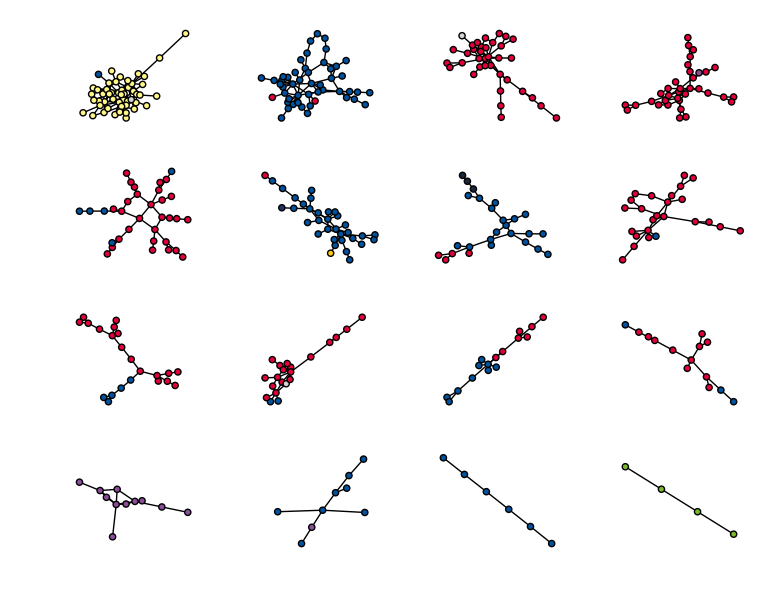

In [147]:
import math
import community
import matplotlib.gridspec

partitions = community.best_partition(G)
n_partitions = max(partition.values())

node_partitions = [[k for k,v in partition.items() if v == i] for i in range(n_partitions)]
node_partitions = sorted(node_partitions, key = len, reverse = True)

subfig_coords = [co for co in matplotlib.gridspec.GridSpec(int(math.ceil(n_partitions/4.)),4)]

number_to_plot = 16
f = matplotlib.pyplot.figure(2, figsize=(9, 18))
for figpos, p in zip(subfig_coords[:number_to_plot], node_partitions[:number_to_plot]):
    H = G.subgraph(p)
    pos = networkx.spring_layout(H, k = .05, iterations = 100)
    f.add_subplot(figpos)
    networkx.draw(H, pos, node_size = 20, node_color = [color_map[G.node[node]['party']] for node in H])

matplotlib.pyplot.show()

In [105]:
subfig_coords = [co for co in matplotlib.gridspec.GridSpec(4,int(math.ceil(n_partitions/4.)))]